In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import Series
from pmdarima import auto_arima

In [2]:
series = pd.read_csv('city_day.csv')
series_delhi = series.loc[series['City'] == 'Delhi']
ts_delhi = series_delhi[['Date','AQI']]
#converting 'Date' column to type 'datetime' so that indexing can happen later
ts_delhi['Date'] = pd.to_datetime(ts_delhi['Date'])

C:\Users\admin\AppData\Local\Temp\ipykernel_9636\476825839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_delhi['Date'] = pd.to_datetime(ts_delhi['Date'])


In [3]:
ts_delhi.isnull().sum()
ts_delhi = ts_delhi.dropna()
ts_delhi.isnull().sum()


Date    0
AQI     0
dtype: int64

In [4]:
ts_delhi = ts_delhi.set_index('Date')


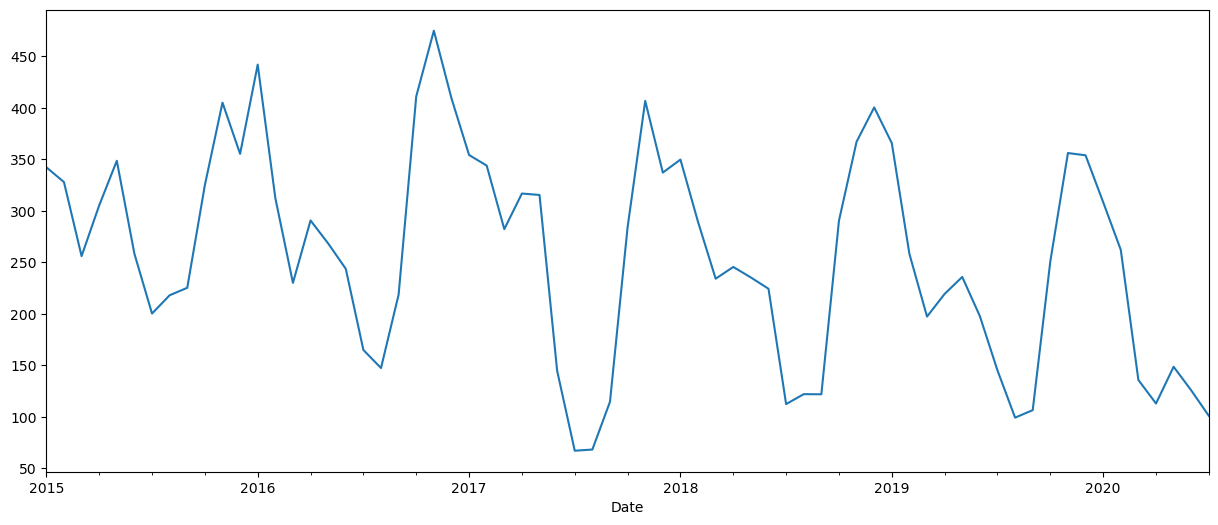

In [5]:
ts_month_avg = ts_delhi['AQI'].resample('MS').mean()
ts_month_avg.plot(figsize = (15, 6))
plt.show()

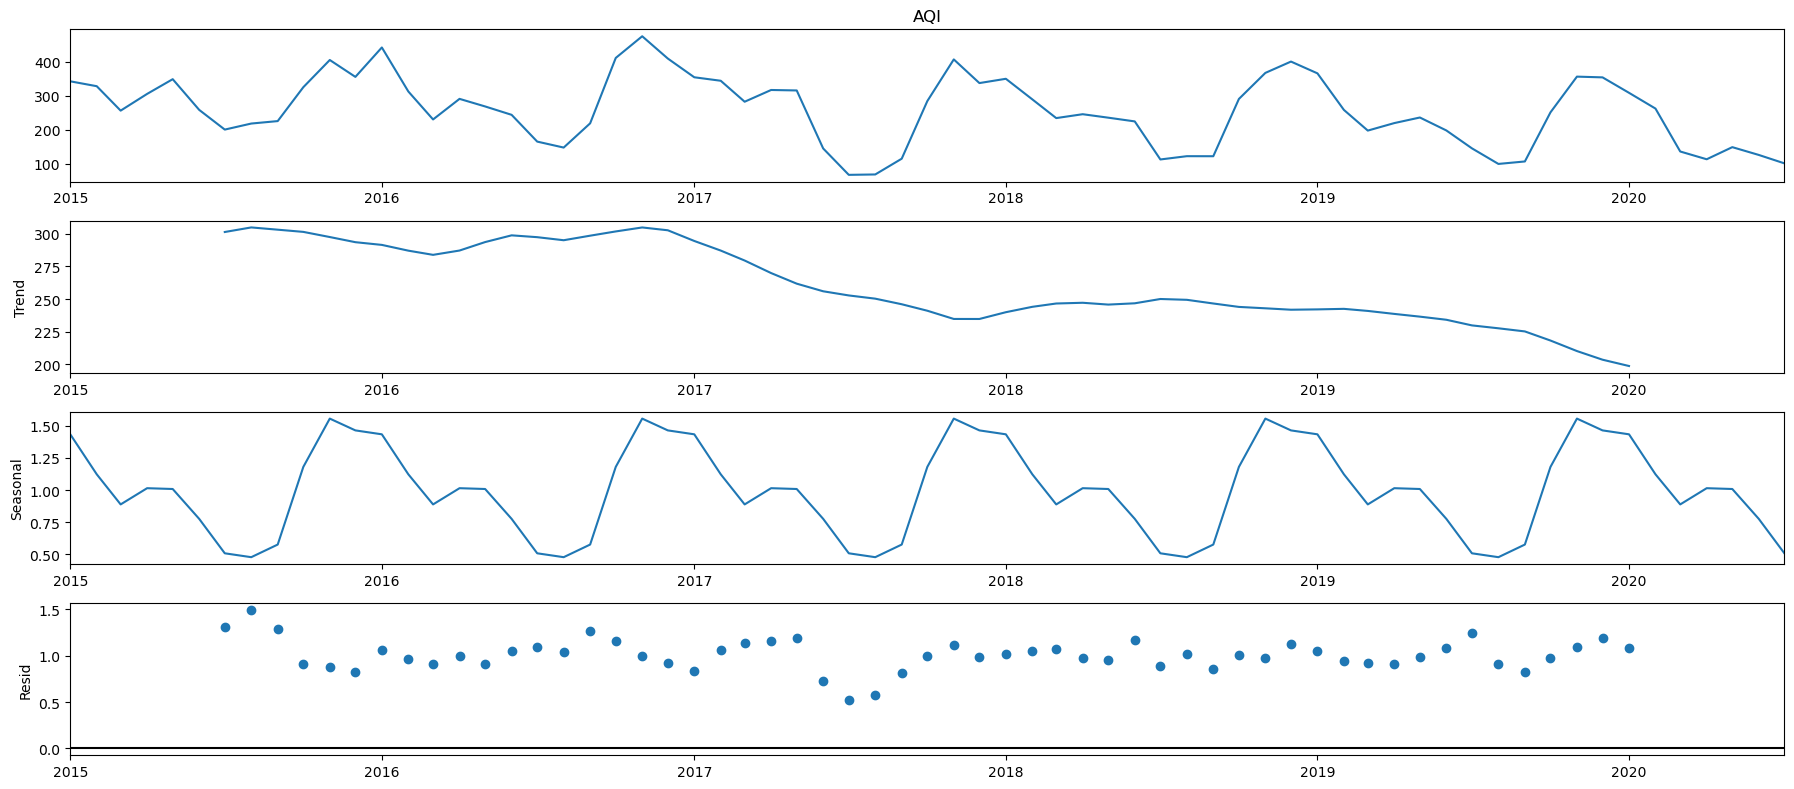

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts_month_avg, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [7]:
adf_test = adfuller(ts_month_avg)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.229024
Critical Values @ 0.05: -2.92
p-value: 0.973843


In [8]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return Series(diff)

In [9]:
ts_t_adj=difference(ts_month_avg)

In [10]:
ts_t_adj=ts_t_adj.dropna()

<AxesSubplot:>

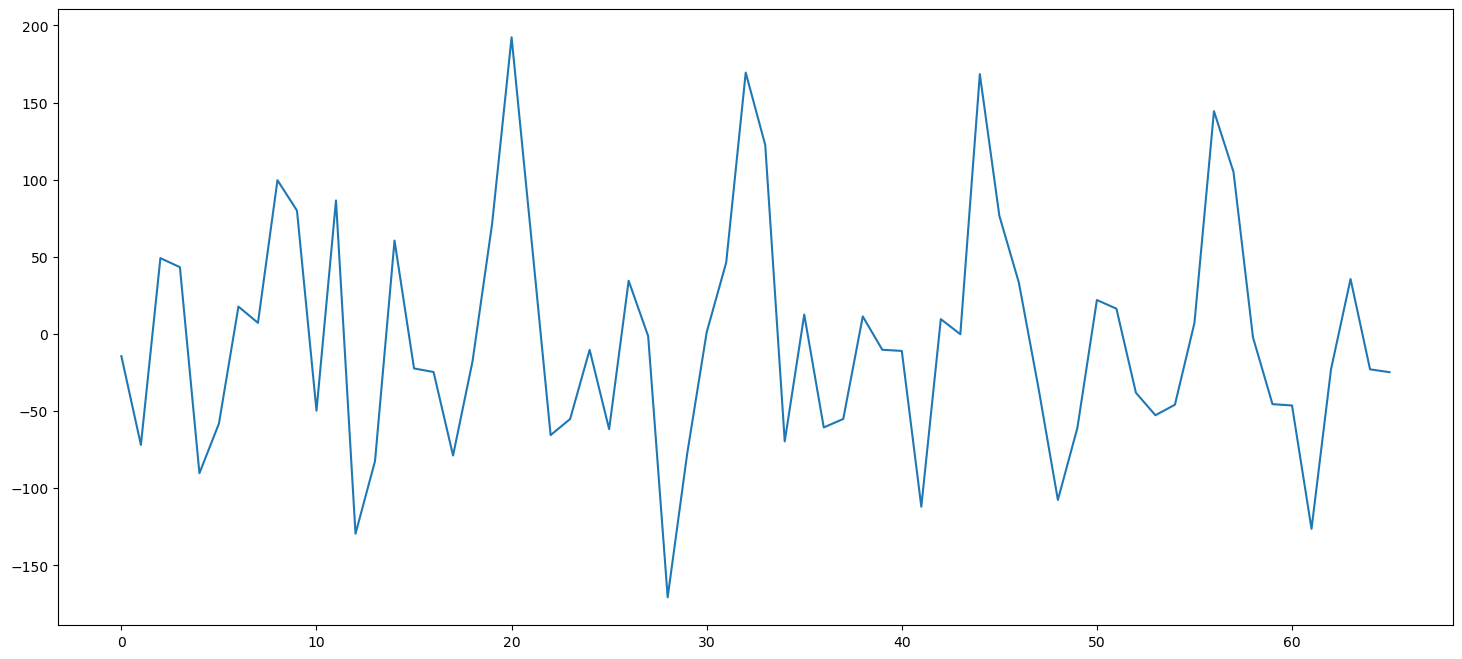

In [11]:
ts_t_adj.plot()

In [12]:
adf_test = adfuller(ts_t_adj)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -6.795995
Critical Values @ 0.05: -2.92
p-value: 0.000000


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_t_adj,lags=25)
plot_pacf(ts_t_adj,lags=25)
plt.show()

In [32]:
train = ts_month_avg[0:54]
test = ts_month_avg[54:]
print('Train Timeseries Range => ', train.index.min(), ' - ' , train.index.max())
print('Test Timeseries Range => ', test.index.min(), ' - ' , test.index.max())


Train Timeseries Range =>  2015-01-01 00:00:00  -  2019-06-01 00:00:00
Train Timeseries Range =>  2019-07-01 00:00:00  -  2020-07-01 00:00:00


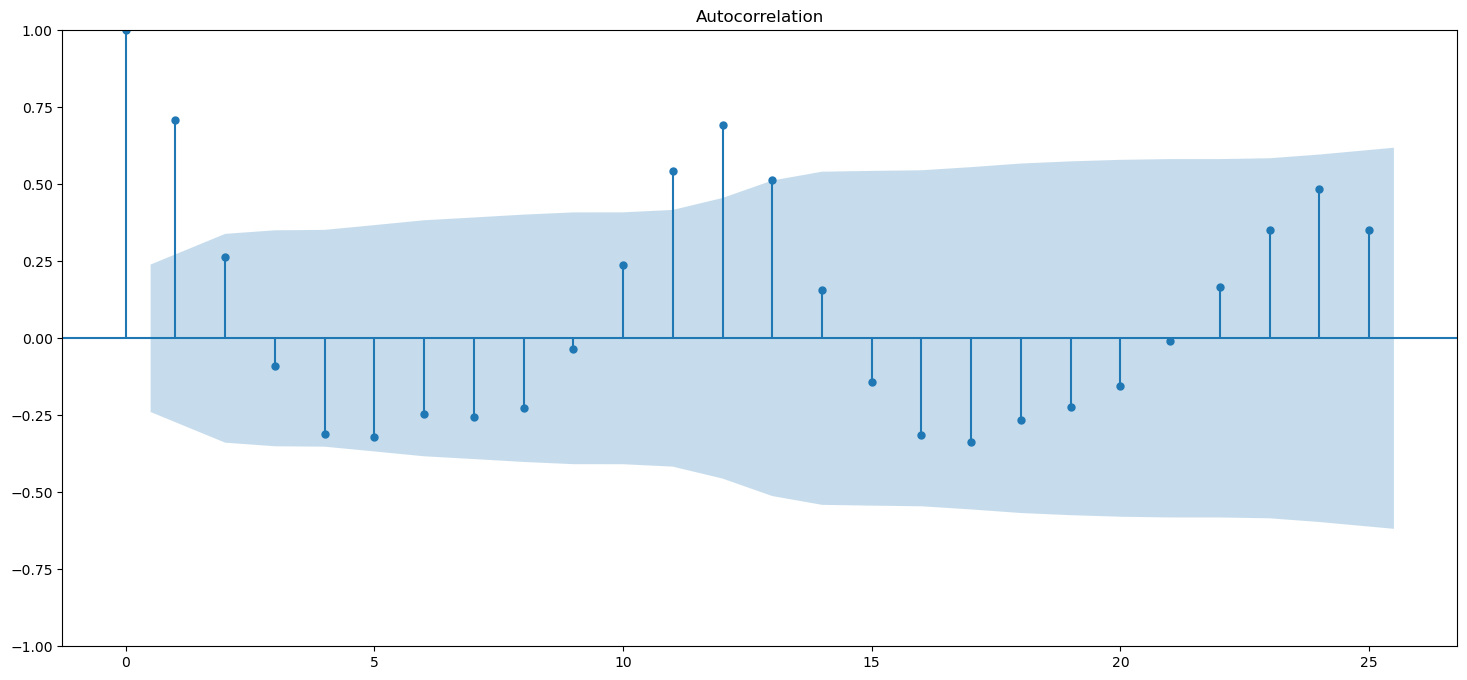

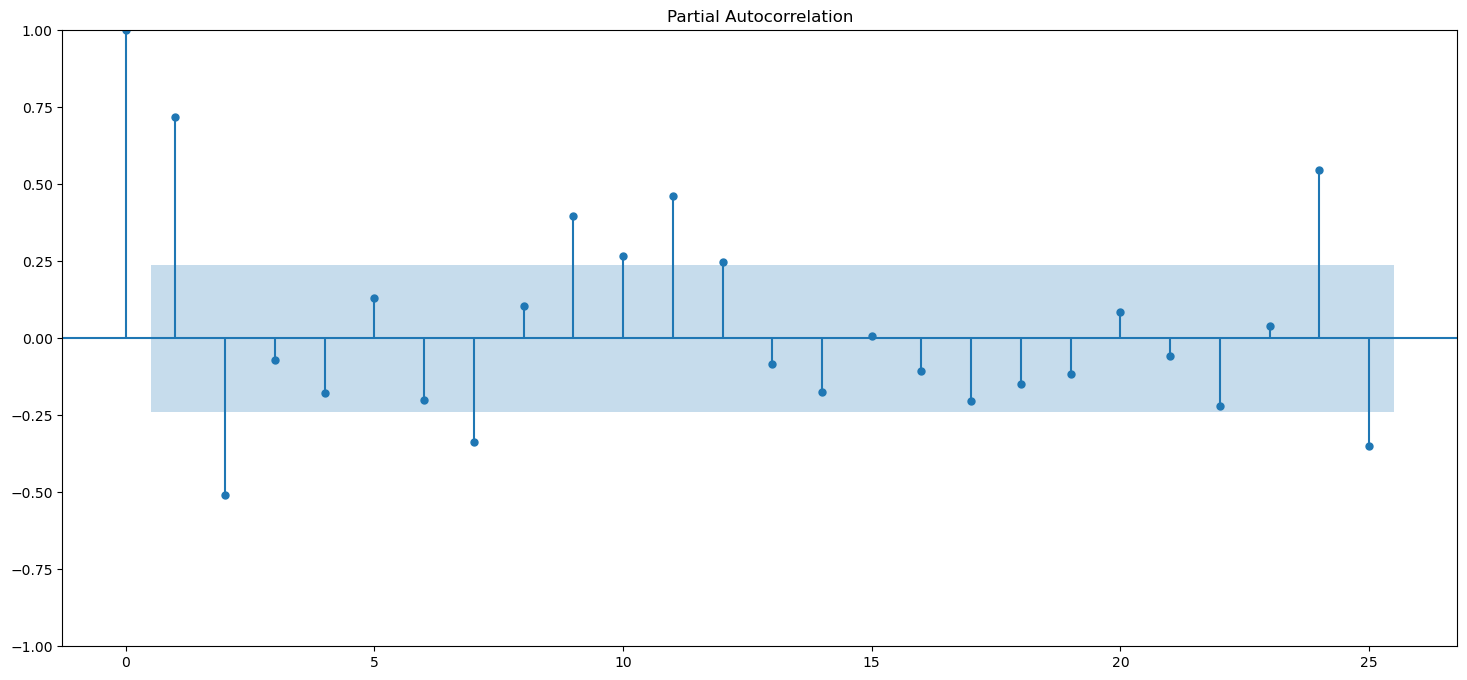

In [14]:
plot_acf(ts_month_avg,lags=25)
plot_pacf(ts_month_avg,lags=25)
plt.show()

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train,order=(1,1,1), seasonal_order=(1,0,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,)

In [34]:
fitted = sarima.fit()
print(fitted.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                AQI   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -202.621
Date:                            Thu, 11 Apr 2024   AIC                            415.243
Time:                                    12:27:18   BIC                            423.561
Sample:                                01-01-2015   HQIC                           418.227
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4705      0.221      2.126      0.034       0.037       0.904
ma.L1         -1.0000   5066.662   

In [35]:
pred_test = fitted.predict(start=test.index.min(), end=test.index.max())

In [36]:
pred_test

2019-07-01    108.937050
2019-08-01    104.261965
2019-09-01    129.514668
2019-10-01    270.469487
2019-11-01    347.573554
2019-12-01    311.647910
2020-01-01    314.989298
2020-02-01    247.692036
2020-03-01    183.130572
2020-04-01    213.222649
2020-05-01    217.018175
2020-06-01    155.935887
2020-07-01     82.266482
Freq: MS, Name: predicted_mean, dtype: float64

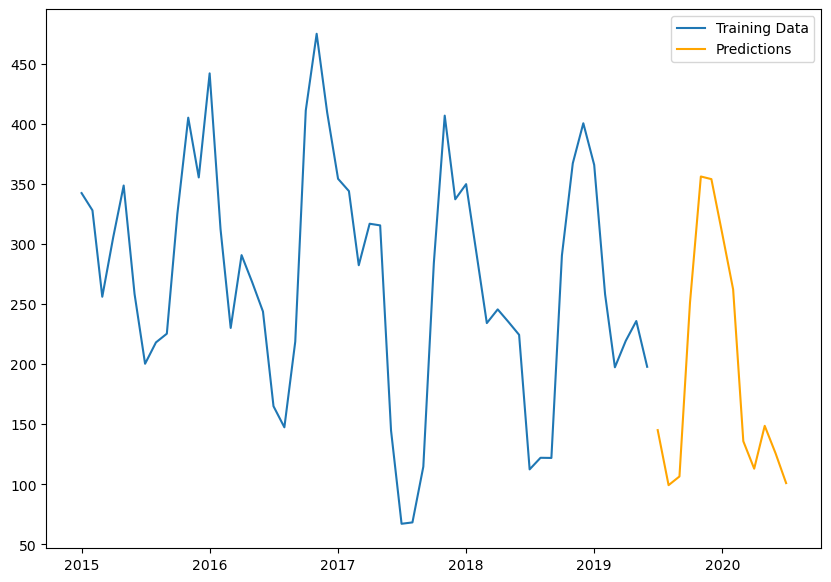

In [37]:
plt.figure(figsize=(10,7))
plt.plot(train.index,train,label='Training Data')
plt.plot(test.index,test, label='Predictions', color='orange')
plt.legend()
plt.show()


In [38]:
ts_month_avg

Date
2015-01-01    342.290323
2015-02-01    327.928571
2015-03-01    256.064516
2015-04-01    305.266667
2015-05-01    348.580645
                 ...    
2020-03-01    135.838710
2020-04-01    113.000000
2020-05-01    148.645161
2020-06-01    125.733333
2020-07-01    101.000000
Freq: MS, Name: AQI, Length: 67, dtype: float64

In [39]:
pred_future = fitted.get_prediction(start=pd.to_datetime('2020-08-01'),end=pd.to_datetime('2020-11-01') ,dynamic=False)

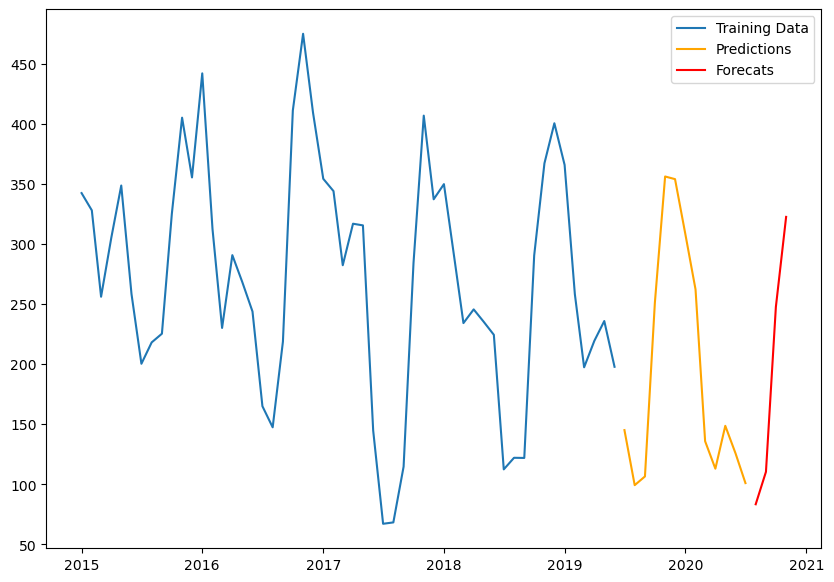

In [40]:
plt.figure(figsize=(10,7))
plt.plot(train.index,train,label='Training Data')
plt.plot(test.index,test, label='Predictions', color='orange')
plt.plot(pred_future.predicted_mean.index,pred_future.predicted_mean.values, label='Forecats', color='red')
plt.legend()
plt.show()


In [41]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(pred_test,test)
print(mae)

32.320856069422824


In [42]:
test.mean()

192.82541570405863

In [162]:
sarima_model = auto_arima(train, start_p=0, start_q=0,
                      max_p=12, max_q=12,
                      m=12,             
                      d=None,             
                      start_P=1,
                      start_Q=1,
                      max_P=10,
                      max_Q=10,
                      test='adf',         # use adftest to find optimal 'd'
                      D=None, 
                      seasonal=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False,
                         information_criterion='aic')

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=649.483, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=624.295, Time=0.11 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=606.491, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=614.981, Time=0.33 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=606.603, Time=0.33 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=608.722

In [150]:
print(sarima_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   54
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -286.885
Date:                              Thu, 11 Apr 2024   AIC                            583.771
Time:                                      13:22:53   BIC                            593.716
Sample:                                  01-01-2015   HQIC                           587.606
                                       - 06-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.8532     21.818      0.406      0.685     -33.909      51.615
ar.L1          0.60

In [163]:
auto=SARIMAX(train,order=(1,0,1), seasonal_order=(2,0,0,12),
                                 enforce_stationarity=False, enforce_invertibility=False,)

In [164]:
fitted_2 = auto.fit()


In [165]:
pred_test_new = fitted_2.predict(start=test.index.min(), end=test.index.max())

In [166]:
pred_test_new

2019-07-01    108.844337
2019-08-01     92.831281
2019-09-01    109.412738
2019-10-01    253.576461
2019-11-01    344.016637
2019-12-01    316.329256
2020-01-01    311.472632
2020-02-01    242.863455
2020-03-01    192.742841
2020-04-01    206.200302
2020-05-01    206.039898
2020-06-01    187.513395
2020-07-01     97.168195
Freq: MS, Name: predicted_mean, dtype: float64

In [167]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(pred_test_new,test)
print(mae)

30.248554644170966
